In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import random
%matplotlib inline
plt.style.use('ggplot')
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
X,Y = sklearn.datasets.make_classification(n_samples=10000,
                                        n_features=5,
                                           n_redundant=0,
                                           n_informative=5,
                                           n_clusters_per_class=1,
                                          class_sep=1,
                                          random_state=3)
X_df, Y_df = pd.DataFrame(X), pd.DataFrame(Y)
Y_df.columns=(['K'])
df_master = pd.concat((X_df,Y_df),axis=1)

In [5]:
def unbalanced_data(drop_no):
    drop_indices = np.random.choice(df_master[df_master['K']==1].index, drop_no, replace=False)
    return df_master.drop(drop_indices)

In [6]:
df_master1 = unbalanced_data(int(.25*len(Y_df[Y_df['K']==1])))
df_master2 = unbalanced_data(int(.75*len(Y_df[Y_df['K']==1])))
df_master3 = unbalanced_data(int(.90*len(Y_df[Y_df['K']==1])))

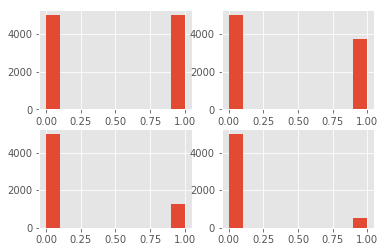

In [7]:
fig, axes = plt.subplots(2, 2)
axes[0,0].hist(df_master['K'])
axes[0,1].hist(df_master1['K'])
axes[1,0].hist(df_master2['K'])
axes[1,1].hist(df_master3['K']);

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(df_master.iloc[:,0:5], df_master.iloc[:,5], test_size=0.33, random_state=42)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(df_master1.iloc[:,0:5], df_master1.iloc[:,5], test_size=0.33, random_state=42)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(df_master2.iloc[:,0:5], df_master2.iloc[:,5], test_size=0.33, random_state=42)
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(df_master3.iloc[:,0:5], df_master3.iloc[:,5], test_size=0.33, random_state=42)

In [55]:
def metrics(actual, preds):
    metrics = sklearn.metrics.confusion_matrix(actual, preds)
    tn, fp, fn, tp = np.ravel(metrics)
    recall = tp/(tp+fn)
    fprate = fp/(tn+fp)
    return recall, fprate

In [57]:
percent = []
for df in [df_master, df_master1, df_master2, df_master3]:
    percent.append(df[df['K']==1].shape[0]/(df[df['K']==1].shape[0]+df[df['K']==0].shape[0]))

In [58]:
gnb = GaussianNB()

In [59]:
preds = gnb.fit(X_train, Y_train).predict(X_test)
recall, fprate = metrics(Y_test, preds)
logpreds = LogisticRegression(solver='sag').fit(X_train, Y_train).predict(X_test)
recalllog, fpratelog = metrics(Y_test, logpreds)
preds1 = gnb.fit(X_train1, Y_train1).predict(X_test1)
recall1, fprate1 = metrics(Y_test1, preds1)
logpreds1 = LogisticRegression(solver='sag').fit(X_train1, Y_train1).predict(X_test1)
recalllog1, fpratelog1 = metrics(Y_test1, logpreds1)
preds2 = gnb.fit(X_train2, Y_train2).predict(X_test2)
recall2, fprate2 = metrics(Y_test2, preds2)
logpreds2 = LogisticRegression(solver='sag').fit(X_train2, Y_train2).predict(X_test2)
recalllog2, fpratelog2 = metrics(Y_test2, logpreds2)
preds3 = gnb.fit(X_train3, Y_train3).predict(X_test3)
recall3, fprate3 = metrics(Y_test3, preds3)
logpreds3 = LogisticRegression(solver='sag').fit(X_train3, Y_train3).predict(X_test3)
recalllog3, fpratelog3 = metrics(Y_test3, logpreds3)

In [60]:
recalllist = [recall, recall1, recall2, recall3]
fpratelist = [fprate, fprate1, fprate2, fprate3]
recalllog = [recalllog, recalllog1, recalllog2, recalllog3]
fpratelog = [fpratelog, fpratelog1, fpratelog2, fpratelog3]

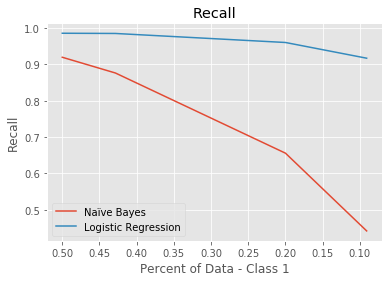

In [62]:
plt.plot(percent, recalllist, label='Naïve Bayes')
plt.plot(percent, recalllog, label='Logistic Regression')
plt.gca().invert_xaxis()
plt.title("Recall")
plt.xlabel("Percent of Data - Class 1")
plt.ylabel("Recall")
plt.legend();

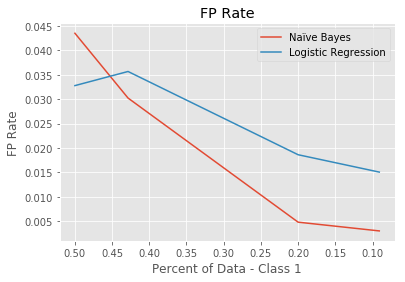

In [64]:
plt.plot(percent, fpratelist, label='Naïve Bayes')
plt.plot(percent, fpratelog, label='Logistic Regression')
plt.gca().invert_xaxis()
plt.title("FP Rate")
plt.xlabel("Percent of Data - Class 1")
plt.ylabel("FP Rate")
plt.legend();

#### Accuracy of Naïve Bayes falls drastically compared to Logistic Regression when we don't attempt to address class imbalance.

### Where does Naïve Bayes go wrong?

#### Here's a simple example to illustrate the effect of class imbalance on Naïve Bayes [Adapted from: Tackling the Poor Assumptions of Naive Bayes Text Classifiers, Rennie et. al]

#### We generate data from 2 classes, each with a binomial feature distribution that takes values 0 or 1. 
#### So when we sample the data, we get Y which takes value 1 or 2 to indicate the class, and X is a binomial distribution with the following probabilities:
#### P(X=1|Y=1) = 0.25
#### P(X=1|Y=2) = 0.2

In [115]:
probs = [0.48, 0.24, 0.03, 0.16, 0.08, 0.01]
class1 = []
class2 = []
labels = []
probcol = []

In [116]:
for i in range(1000):
    p = np.random.choice(probs, p=probs)
    if p == 0.48:
        class1.append(0)
        class2.append((0,0))
    if p == 0.24:
        class1.append(0)
        class2.append((1,0))
    if p == 0.03:
        class1.append(0)
        class2.append((1,1))
    if p == 0.16:
        class1.append(1)
        class2.append((0,0))
    if p == 0.08:
        class1.append(1)
        class2.append((1,0))
    if p == 0.01:
        class1.append(1)
        class2.append((1,1))
    probcol.append(p)
    labels.append((1,2,2))

In [117]:
df = pd.DataFrame({"class 1":class1, "class 2":class2, "labels":labels, "sample probability":probcol})
df = shuffle(df)

In [119]:
df['thetahat1'] = df['class 1']/1
thetahat2 = []
for i in range(len(df['class 2'])):
    thetahat2.append((df['class 2'][i][0] + df['class 2'][i][1])/2)
df['thetahat2'] = thetahat2

In [121]:
df['label for 1'] = np.where((df['thetahat1'] == 0.0) & (df['thetahat2'] == 0.0), 0, (np.where(df['thetahat1']>df['thetahat2'], 1, 2)))

In [122]:
labelnot0 = df[df['label for 1'] != 0]

In [137]:
labelnot0.shape

(546, 7)

In [133]:
sum(labelnot0['label for 1']==1)

201

In [134]:
sum(labelnot0['label for 1']==2)

345

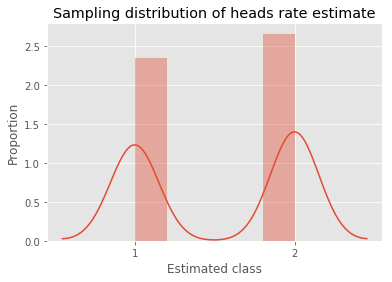

In [123]:
sns.distplot(labelnot0['label for 1'])
plt.title("Sampling distribution of parameter")
plt.xlabel("Estimated class")
plt.ylabel("Proportion")
plt.xticks([1,2]);

#### Even though class 1 has a higher rate of heads in the population, the sampling distribution indicates that the Naïve Bayes model predicts a higher rate of heads for class 2 more often.

#### It's clear to see that the prior probability that we compute from our data influences Naïve Bayes predictions. Having twice as much training data for class 2 than class 1 leads to a classifier that predicts class 2 more often, even though the distribution does not follow suit.  

#### What happens when we have more training data for class 2 and class 2 also has the higher rate of heads? Does the imbalanced training data and therefore the higher prior probability still negatively impact classification?

#### Redefining P(X=1|Y=1) = 0.2 and P(X=1|Y=2) = 0.25

In [124]:
probs = [0.45, 0.3, 0.05, 0.1125, 0.075, 0.0125]
class1 = []
class2 = []
labels = []
probcol = []

In [125]:
for i in range(1000):
    p = np.random.choice(probs, p=probs)
    if p == 0.45:
        class1.append(0)
        class2.append((0,0))
    if p == 0.3:
        class1.append(0)
        class2.append((1,0))
    if p == 0.05:
        class1.append(0)
        class2.append((1,1))
    if p == 0.1125:
        class1.append(1)
        class2.append((0,0))
    if p == 0.075:
        class1.append(1)
        class2.append((1,0))
    if p == 0.0125:
        class1.append(1)
        class2.append((1,1))
    probcol.append(p)
    labels.append((1,2,2))

In [126]:
df = pd.DataFrame({"class 1":class1, "class 2":class2, "labels":labels, "sample probability":probcol})
df = shuffle(df)

In [127]:
df['thetahat1'] = df['class 1']/1
thetahat2 = []
for i in range(len(df['class 2'])):
    thetahat2.append((df['class 2'][i][0] + df['class 2'][i][1])/2)
df['thetahat2'] = thetahat2

In [128]:
df['label for 1'] = np.where((df['thetahat1'] == 0.0) & (df['thetahat2'] == 0.0), 0, (np.where(df['thetahat1']>df['thetahat2'], 1, 2)))

In [129]:
labelnot0 = df[df['label for 1'] != 0]

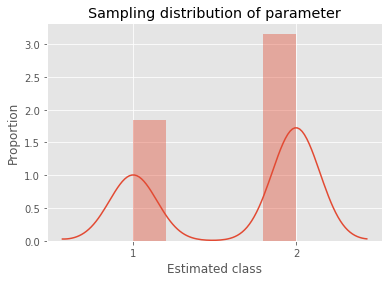

In [141]:
sns.distplot(labelnot0['label for 1'])
plt.title("Sampling distribution of parameter")
plt.xlabel("Estimated class")
plt.ylabel("Proportion")
plt.xticks([1,2]);

#### This is definitely consistent with the data unlike the previous case. So it's possible that the prior probability is not as much of a problem when the sample proportions of the classes is more reflective of the true parameter values. However, it's highly unlikely that we know in advance the true prior probabilities of the classes, so we need to think about fixes for the class imbalance problem.

#### Oversampling is a common fix for the problem of imbalanced classes. However, the main focus of this section will be the functioning of the Naïve Bayes classifier - why it's impacted by unbalanced classes more than discriminative classifiers like Logistic Regression, and how we can improve the classifier.

#### The alternative we want to explore is Complement Naïve Bayes, which is a modified version of Naïve Bayes which tackles the class imbalance problem in a way that ensures the model is trained on an equal amount of data for each class.

### Complement Naïve Bayes vs. Naïve Bayes

In [3]:
filepath_dict = {'yelp':   'Desktop/DS5220-NaiveBayes/data/yelp_labelled.txt',
                 'amazon': 'Desktop/DS5220-NaiveBayes/data/amazon_cells_labelled.txt',
                 'imdb':   'Desktop/DS5220-NaiveBayes/data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [8]:
df_yelp = df[df['source'] == 'yelp']

In [11]:
def unbalanced_data(drop_no, df):
    drop_indices = np.random.choice(df[df['label']==1].index, drop_no, replace=False)
    return df.drop(drop_indices)

In [12]:
df_master1 = unbalanced_data(int(.25*len(df_yelp[df_yelp['label']==1])), df_yelp)
df_master2 = unbalanced_data(int(.75*len(df_yelp[df_yelp['label']==1])), df_yelp)
df_master3 = unbalanced_data(int(.90*len(df_yelp[df_yelp['label']==1])), df_yelp)

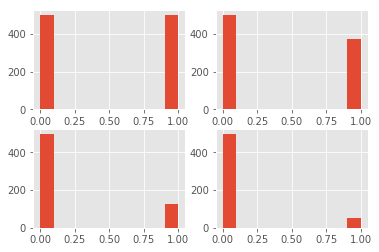

In [13]:
fig, axes = plt.subplots(2, 2)
axes[0,0].hist(df_yelp['label'])
axes[0,1].hist(df_master1['label'])
axes[1,0].hist(df_master2['label'])
axes[1,1].hist(df_master3['label']);

In [14]:
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)
sentences1 = df_master1['sentence'].values
y1 = df_master1['label'].values
sentences_train1, sentences_test1, y_train1, y_test1 = train_test_split(sentences1, y1, test_size=0.25, random_state=1000)
sentences2 = df_master2['sentence'].values
y2 = df_master2['label'].values
sentences_train2, sentences_test2, y_train2, y_test2 = train_test_split(sentences2, y2, test_size=0.25, random_state=1000)
sentences3 = df_master3['sentence'].values
y3 = df_master3['label'].values
sentences_train3, sentences_test3, y_train3, y_test3 = train_test_split(sentences3, y3, test_size=0.25, random_state=1000)

In [15]:
def metrics(actual, preds):
    metrics = sklearn.metrics.confusion_matrix(actual, preds)
    tn, fp, fn, tp = np.ravel(metrics)
    recall = tp/(tp+fn)
    fprate = fp/(tn+fp)
    return recall, fprate

In [16]:
percent = []
for df in [df_yelp, df_master1, df_master2, df_master3]:
    percent.append(df[df['label']==1].shape[0]/(df[df['label']==1].shape[0]+df[df['label']==0].shape[0]))

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
vectorizer1 = CountVectorizer()
vectorizer1.fit(sentences_train1)
vectorizer2 = CountVectorizer()
vectorizer2.fit(sentences_train2)
vectorizer3 = CountVectorizer()
vectorizer3.fit(sentences_train3)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train1 = vectorizer.transform(sentences_train1)
X_test1  = vectorizer.transform(sentences_test1)
X_train2 = vectorizer.transform(sentences_train2)
X_test2  = vectorizer.transform(sentences_test2)
X_train3 = vectorizer.transform(sentences_train3)
X_test3  = vectorizer.transform(sentences_test3)

In [19]:
clflog = LogisticRegression()
clfbn = BernoulliNB()
clfcnb = ComplementNB()

In [20]:
preds = clfbn.fit(X_train, y_train).predict(X_test)
recall, fprate = metrics(y_test, preds)
logpreds = clflog.fit(X_train, y_train).predict(X_test)
recalllog, fpratelog = metrics(y_test, logpreds)
predscnb = clfcnb.fit(X_train, y_train).predict(X_test)
recallcnb, fpratecnb = metrics(y_test, predscnb)

preds1 = clfbn.fit(X_train1, y_train1).predict(X_test1)
recall1, fprate1 = metrics(y_test1, preds1)
logpreds1 = clflog.fit(X_train1, y_train1).predict(X_test1)
recalllog1, fpratelog1 = metrics(y_test1, logpreds1)
predscnb1 = clfcnb.fit(X_train1, y_train1).predict(X_test1)
recallcnb1, fpratecnb1 = metrics(y_test1, predscnb1)

preds2 = clfbn.fit(X_train2, y_train2).predict(X_test2)
recall2, fprate2 = metrics(y_test2, preds2)
logpreds2 = clflog.fit(X_train2, y_train2).predict(X_test2)
recalllog2, fpratelog2 = metrics(y_test2, logpreds2)
predscnb2 = clfcnb.fit(X_train2, y_train2).predict(X_test2)
recallcnb2, fpratecnb2 = metrics(y_test2, predscnb2)

preds3 = clfbn.fit(X_train3, y_train3).predict(X_test3)
recall3, fprate3 = metrics(y_test3, preds3)
logpreds3 = clflog.fit(X_train3, y_train3).predict(X_test3)
recalllog3, fpratelog3 = metrics(y_test3, logpreds3)
predscnb3 = clfcnb.fit(X_train3, y_train3).predict(X_test3)
recallcnb3, fpratecnb3 = metrics(y_test3, predscnb3)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
recalllist = [recall, recall1, recall2, recall3]
fpratelist = [fprate, fprate1, fprate2, fprate3]
recalllog = [recalllog, recalllog1, recalllog2, recalllog3]
fpratelog = [fpratelog, fpratelog1, fpratelog2, fpratelog3]
recallcnb = [recallcnb, recallcnb1, recallcnb2, recallcnb3]
fpratecnb = [fpratecnb, fpratecnb1, fpratecnb2, fpratecnb3]

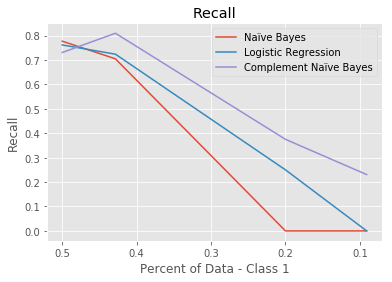

In [22]:
plt.plot(percent, recalllist, label='Naïve Bayes')
plt.plot(percent, recalllog, label='Logistic Regression')
plt.plot(percent, recallcnb, label='Complement Naïve Bayes')
plt.gca().invert_xaxis()
plt.title("Recall")
plt.xlabel("Percent of Data - Class 1")
plt.ylabel("Recall")
plt.legend();

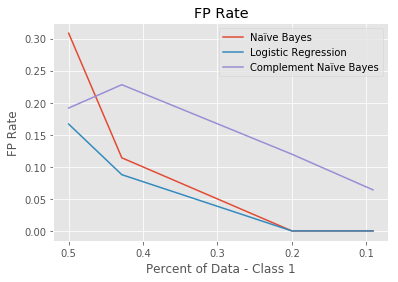

In [23]:
plt.plot(percent, fpratelist, label='Naïve Bayes')
plt.plot(percent, fpratelog, label='Logistic Regression')
plt.plot(percent, fpratecnb, label='Complement Naïve Bayes')
plt.gca().invert_xaxis()
plt.title("FP Rate")
plt.xlabel("Percent of Data - Class 1")
plt.ylabel("FP Rate")
plt.legend();

#### Using Complement Naïve Bayes instead of Bernoulli Naïve Bayes, we are able to achieve an almost similar performance to Logistic Regression, even with severe class imbalance.